In [148]:
import os
import math
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
path = "/Users/jorgerag/Documents/UCSD/courses/Winter23/COGS181/final_project/"
os.chdir(path)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [99]:
def get_source(df):
    res = []
    for i in range(0, len(df)):
        res.append(np.array(df["gcamp_lp"].iloc[i], dtype="float32"))
    res = np.array(res)
    return torch.from_numpy(res[1:])

In [ ]:
class PositionalEncoding(
    nn.Module,
):
    # needs to go at the bottom of the encoder and decoder stacks
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 3000):
        super().__init__()

        # Hyperparameter: to introduce regularization that prevents against overfitting
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        pe = torch.squeeze(pe)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :].requires_grad_(False)
        return self.dropout(x)

In [ ]:
class Transformer(nn.Module):

    # input var
    def __init__(
        self,
        num_input_variables,
        dim_val,
        encoder_dim_feedforward_d_model_scalar,
        encoder_dropout,
        encoder_num_layers,
        encoder_activation,
        encoder_num_heads,
        decoder_dim_feedforward_d_model_scalar,
        decoder_dropout,
        decoder_num_layers,
        decoder_num_heads,
        decoder_activation,
        max_seq,
    ):

        super().__init__()

        self.encoder_input_layer = nn.Linear(in_features=max_seq, out_features=dim_val)

        self.positional_encoding = PositionalEncoding(dim_val, max_len=max_seq)

        # dim_feedforward must be a scalar of d_model value
        # dropout: since a larger dropout is needed within the hidden layers, ensure that it can be up to .5
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=encoder_num_heads,
            dim_feedforward=dim_val * encoder_dim_feedforward_d_model_scalar,
            dropout=encoder_dropout,
            activation=encoder_activation,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=encoder_num_layers)

        self.decoder_input_layer = nn.Linear(in_features=num_input_variables, out_features=dim_val)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=decoder_num_heads,
            dim_feedforward=dim_val * decoder_dim_feedforward_d_model_scalar,
            dropout=decoder_dropout,
            activation=decoder_activation,
        )

        self.decoder = nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=decoder_num_layers)

        self.linear_mapping = nn.Linear(in_features=dim_val, out_features=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, source, target):
        source = self.encoder_input_layer(source)
        source = self.positional_encoding(source)
        source = self.encoder(src=source)
        target = self.decoder_input_layer(target)
        target = self.decoder(tgt=target, memory=source)
        target = self.linear_mapping(target)
        target = self.sigmoid(target)
        return target

In [176]:
dim_val = 100
n_heads = 10
n_decoder_layers = 4
n_encoder_layers = 4
max_seq = 703
epochs = 50
lr = 0.0001
momentum = 0.9
loss_function = torch.nn.BCELoss()

trainingset = pd.DataFrame(pd.read_json("data/processed/train_data.json"))
testset = pd.DataFrame(pd.read_json("data/processed/test_data.json"))
# drop infs
trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]

## Divide dataset by trials
gb = trainingset.groupby(["subject", "day"])
trials = [gb.get_group(x) for x in gb.groups]

gb_test = testset.groupby(["subject", "day"])
test_trials = [gb_test.get_group(x) for x in gb_test.groups]

/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_55598/1159211150.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  trainingset = trainingset[~trainingset.isin([np.nan, np.inf, -np.inf]).any(1)]
/var/folders/mj/fbzmtcxx50g7hksjvdvr0kh00000gn/T/ipykernel_55598/1159211150.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  testset = testset[~testset.isin([np.nan, np.inf, -np.inf]).any(1)]


In [177]:
model = Transformer(
    num_input_variables=1,
    dim_val=dim_val,
    encoder_dim_feedforward_d_model_scalar=5,
    encoder_dropout=0.5,
    encoder_num_layers=n_encoder_layers,
    encoder_activation="relu",
    encoder_num_heads=n_heads,
    decoder_dim_feedforward_d_model_scalar=5,
    decoder_dropout=0.5,
    decoder_num_layers=n_decoder_layers,
    decoder_num_heads=n_heads,
    decoder_activation="relu",
    max_seq=max_seq,
)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [178]:
all_losses = []
for epoch in range(epochs):
    train_loss = 0
    target_list = []
    predicted_list = []
    model.train()
    for trial in trials:
        optimizer.zero_grad()
        source = get_source(trial)
        # Padding source to max lenght of sequence
        source = F.pad(source, pad=(0, 0, 0, max_seq + 1 - len(trial)), mode="constant", value=0).T
        residual = source
        target = torch.tensor(trial["lp_met"][1:].values)
        target = target.unsqueeze(1).type(torch.FloatTensor)
        target_list = target_list + torch.squeeze(target).tolist()
        predicted_lp = model(source=source, target=target)
        predicted_list = predicted_list + torch.squeeze(predicted_lp).tolist()
        try:
            loss = loss_function(predicted_lp, target)
        except:
            raise SystemExit("Vanishing gradients.")
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * source.size(1)
    all_losses.append(train_loss / len(trials))
    print("-------------------------------------")
    print("Average training Loss:", train_loss / len(trials))
    print("Training ROCAUC Score:", roc_auc_score(np.array(target_list), np.array(predicted_list)))
    ## Calculate ROCAUC testset
    model.eval()
    target_test_list = []
    predicted_test_list = []
    for test in test_trials:
        source_test = get_source(test)
        source_test = F.pad(source_test, pad=(0, 0, 0, max_seq + 1 - len(test)), mode="constant", value=0).T
        target_test = torch.tensor(test["lp_met"][1:].values)
        target_test = target_test.unsqueeze(1).type(torch.FloatTensor)
        target_test_list = target_test_list + torch.squeeze(target_test).tolist()
        with torch.no_grad():
            predicted_test = model(source=source_test, target=target_test)
            predicted_test_list = predicted_test_list + torch.squeeze(predicted_test).tolist()
    print("Test ROCAUC Score:", roc_auc_score(np.array(target_test_list), np.array(predicted_test_list)))

-------------------------------------
Average training Loss: 63.896915674209595
Training ROCAUC Score: 0.42525139141417645
Test ROCAUC Score: 0.37372481241042066
-------------------------------------
Average training Loss: 62.48341345787048
Training ROCAUC Score: 0.5060513215543126
Test ROCAUC Score: 0.8782737159981913
-------------------------------------
Average training Loss: 61.177839040756226
Training ROCAUC Score: 0.5282983340041731
Test ROCAUC Score: 0.9939641759471454
-------------------------------------
Average training Loss: 60.409809708595276
Training ROCAUC Score: 0.562082228760982
Test ROCAUC Score: 1.0
-------------------------------------
Average training Loss: 59.579546332359314
Training ROCAUC Score: 0.593298426533794
Test ROCAUC Score: 1.0
-------------------------------------
Average training Loss: 58.634342551231384
Training ROCAUC Score: 0.6142113931722393
Test ROCAUC Score: 1.0
-------------------------------------
Average training Loss: 57.58309316635132
Trainin

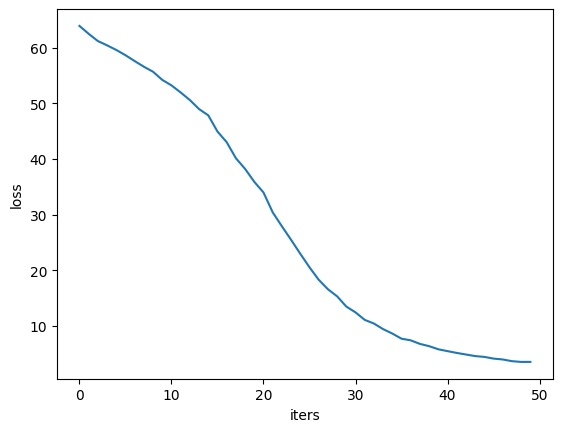

In [179]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot([loss for loss in all_losses])
plt.show()